<p style="background:#83739E; color:white; font-size: 2.1em; text-align:center"> 
    <br><b>Risk Evaluation for Retail Banks</b><br>
    <br>Model Selection and Testing<br><br> 
</p>

<p style="text-align: right;">Module 4: Machine Learning<br>
Sprint 4: Machine Learning Capstone Project<br>
Author : Renato Mariano</p>

<h1 style="color:#774CAD">Introduction </h1>

Welcome to the Capstone Project of of the Machine Learning Module! In this sprint, we embark on an exciting journey to develop a **risk evaluation service for retail banks**, leveraging the power of data science and machine learning.

This work is part of a series of notebooks starting with 01_EDA_application.

<h2 style="color:#774CAD">Library Imports and Notebook Setup</h2>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from rapidfuzz import process
import re

import utils
import EDA
import feat_eng
import pipelines
import model_select

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, OrdinalEncoder, OneHotEncoder
from feature_engine.encoding import RareLabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils.class_weight import compute_class_weight
from scipy.stats import randint, uniform

from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score, recall_score, make_scorer, classification_report
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

In [2]:
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.float_format', lambda x: '%.3f' % x)

from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

%load_ext blackcellmagic

<h1 style="color:#774CAD">Data Transformations</h1>

We start by loading our dataframes and applying our changes / pipelines to the data. We also read our test dataset and apply the same changes to it.

<div class="alert alert-block alert-danger">
<b>Danger:</b> SKIP ROWS ACTIVATED
</div>

In [3]:
df_train = utils.load_df(file_path="data/df_train.csv")
df_valid = utils.load_df(file_path="data/df_validation.csv")
df_test = utils.load_df(file_path="data/df_test.csv")

df_previous = utils.load_df(file_path="data/home-credit-default-risk/previous_application.csv")
df_installments = utils.load_df(file_path="data/home-credit-default-risk/installments_payments.csv")
df_bureau = utils.load_df(file_path="data/home-credit-default-risk/bureau.csv")
feats_to_keep = utils.load_df(file_path="data/feats_to_keep.csv")

The shape of the data is: (153755, 122)
load_df took 2.012 seconds

The shape of the data is: (61502, 122)
load_df took 0.944 seconds

The shape of the data is: (92254, 122)
load_df took 1.263 seconds

The shape of the data is: (1670214, 37)
load_df took 8.231 seconds

The shape of the data is: (13605401, 8)
load_df took 15.910 seconds

The shape of the data is: (1716428, 17)
load_df took 3.850 seconds

The shape of the data is: (32, 1)
load_df took 0.017 seconds



In [4]:
df_previous_transf = feat_eng.PreviousApplicationTransformer().fit_transform(df_previous)
df_installments_transf = feat_eng.InstallmentsTransformer().fit_transform(df_installments)
df_bureau_transf = feat_eng.BureauTransformer().fit_transform(df_bureau)

In [5]:
def preprocess_and_drop_features(
    df, df_previous_transf, df_installments_transf, feats_to_keep
):
    df_transformed = df.merge(df_previous_transf, on="SK_ID_CURR", how="left").merge(
        df_installments_transf, on="SK_ID_CURR", how="left"
    ).merge(
        df_bureau_transf, on="SK_ID_CURR", how="left"
    )

    X = df_transformed.drop(["TARGET", "SK_ID_CURR"], axis=1)
    y = df_transformed["TARGET"]

    feat_eng_pipe2 = Pipeline(
    steps=[
        ("drop_mode_avg", feat_eng.DropModeAVG()),
        ('zero_null_transformer', feat_eng.ZeroToNullTransformer(columns="YEARS_BEGINEXPLUATATION_MEDI")),
        ('multiply_by_neg1', feat_eng.MultiplyByNeg1(columns=[col for col in df.columns if col.startswith('DAYS_')])),
        ('days_empl_anomaly', feat_eng.HandleDaysEmployedAnomaly()),
        ('map_loan_titles', feat_eng.ApplyMapToOrganization(column="ORGANIZATION_TYPE", similarity_threshold=70)),
        ('ext_sources_transformer', feat_eng.ExternalSourcesTransformer()),
        ('financial_ratio_transformer', feat_eng.FinancialRatioTransformer()),
        ('age_employment_transformer', feat_eng.AgeAndEmploymentTransformer()),
        ]
    )

    X_FE = feat_eng_pipe2.fit_transform(X)
    num_feats, cat_feats, binary_feats, highcard_feats = utils.extract_features(X_FE)

    preprocess_pipe = pipelines.create_preprocess_pipeline(
        num_feats, binary_feats, highcard_feats
    )
    X_ready = preprocess_pipe.fit_transform(X_FE)

    # Keep selected columns and rename because of LGMB error.
    X_ready = X_ready.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '_', x))
    X_ready = X_ready[feats_to_keep["Feature"].to_list()]
    
    return X_ready, y

In [6]:
df_train["NAME_EDUCATION_TYPE"].value_counts()

NAME_EDUCATION_TYPE
Secondary / secondary special    109132
Higher education                  37457
Incomplete higher                  5161
Lower secondary                    1919
Academic degree                      86
Name: count, dtype: int64

In [7]:
X_train, y_train = preprocess_and_drop_features(
    df=df_train,
    df_previous_transf=df_previous_transf,
    df_installments_transf=df_installments_transf,
    feats_to_keep=feats_to_keep,
)
print(X_train.shape, y_train.size)
X_train.head(3)

(153755, 32) 153755


,num__AMT_CREDIT,num__AMT_ANNUITY,num__DAYS_BIRTH,num__DAYS_EMPLOYED,num__OWN_CAR_AGE,num__REG_CITY_NOT_LIVE_CITY,num__EXT_SOURCE_1,num__EXT_SOURCE_2,num__EXT_SOURCE_3,num__PREV_name_contract_refused,...,num__BU_debt_credit_sum_ratio_max,num__EXT_SOURCES_prod,num__EXT_SOURCES_sum,num__EXT_SOURCES_mean,num__amt_credit_annuity_ratio,num__amt_goods_price_annuity_ratio,num__amt_goods_price_credit_ratio,num__amt_goods_price_children_ratio,num__days_employed_percent,cat__NAME_EDUCATION_TYPE_Higher_education
0,-0.618,-0.878,-0.969,-0.244,NaN,1.000,-1.233,-1.375,NaN,0.500,...,NaN,-0.754,-1.353,-1.848,0.000,0.056,0.642,-0.337,0.023,0.000
1,1.246,0.545,0.012,-0.179,0.300,1.000,0.061,0.152,NaN,NaN,...,-0.796,0.393,-0.013,0.204,1.229,0.742,-0.671,0.269,-0.256,1.000
2,1.918,0.885,-0.368,0.441,NaN,0.000,0.027,0.046,0.197,NaN,...,-0.758,-0.145,0.856,0.184,1.554,1.391,-0.125,0.721,0.542,1.000


In [8]:
X_valid, y_valid = preprocess_and_drop_features(
    df=df_valid,
    df_previous_transf=df_previous_transf,
    df_installments_transf=df_installments_transf,
    feats_to_keep=feats_to_keep,
)
print(X_valid.shape, y_valid.size)
X_valid.head(3)

(61502, 32) 61502


,num__AMT_CREDIT,num__AMT_ANNUITY,num__DAYS_BIRTH,num__DAYS_EMPLOYED,num__OWN_CAR_AGE,num__REG_CITY_NOT_LIVE_CITY,num__EXT_SOURCE_1,num__EXT_SOURCE_2,num__EXT_SOURCE_3,num__PREV_name_contract_refused,...,num__BU_debt_credit_sum_ratio_max,num__EXT_SOURCES_prod,num__EXT_SOURCES_sum,num__EXT_SOURCES_mean,num__amt_credit_annuity_ratio,num__amt_goods_price_annuity_ratio,num__amt_goods_price_credit_ratio,num__amt_goods_price_children_ratio,num__days_employed_percent,cat__NAME_EDUCATION_TYPE_Higher_education
0,1.258,0.556,-0.392,-0.495,NaN,0.000,NaN,-1.131,-0.489,-0.500,...,-0.799,-0.426,-0.766,-0.946,1.222,0.740,-0.671,1.282,-0.517,1.000
1,1.890,0.960,0.870,NaN,NaN,0.000,NaN,0.600,-0.651,NaN,...,0.040,0.125,-0.114,0.049,1.411,1.717,0.642,2.573,NaN,0.000
2,0.017,0.575,-0.016,-0.289,NaN,0.000,NaN,-0.629,-0.613,NaN,...,0.266,-0.283,-0.612,-0.712,-0.453,-0.680,-0.185,0.243,-0.359,0.000


In [9]:
X_test, y_test= preprocess_and_drop_features(
    df=df_test,
    df_previous_transf=df_previous_transf,
    df_installments_transf=df_installments_transf,
    feats_to_keep=feats_to_keep,
)
print(X_test.shape, y_test.size)
X_test.head(3)

(92254, 32) 92254


,num__AMT_CREDIT,num__AMT_ANNUITY,num__DAYS_BIRTH,num__DAYS_EMPLOYED,num__OWN_CAR_AGE,num__REG_CITY_NOT_LIVE_CITY,num__EXT_SOURCE_1,num__EXT_SOURCE_2,num__EXT_SOURCE_3,num__PREV_name_contract_refused,...,num__BU_debt_credit_sum_ratio_max,num__EXT_SOURCES_prod,num__EXT_SOURCES_sum,num__EXT_SOURCES_mean,num__amt_credit_annuity_ratio,num__amt_goods_price_annuity_ratio,num__amt_goods_price_credit_ratio,num__amt_goods_price_children_ratio,num__days_employed_percent,cat__NAME_EDUCATION_TYPE_Higher_education
0,-0.591,-0.740,0.845,NaN,-0.400,0.000,NaN,0.074,0.828,NaN,...,-0.797,0.922,0.356,0.766,-0.242,-0.589,-0.621,-0.386,NaN,0.000
1,-0.187,-0.121,-0.598,0.425,NaN,0.000,NaN,0.373,0.030,NaN,...,-0.167,0.557,0.107,0.388,-0.146,-0.368,-0.185,0.043,0.706,0.000
2,1.044,0.367,0.490,-0.550,-0.300,0.000,0.829,0.465,-0.867,-0.500,...,0.280,-0.247,0.964,0.295,1.238,1.480,0.642,1.567,-0.625,0.000


<h1 style="color:#C1524B">Model Selection</h1>

The following modeling solutions were defined. We start off by **setting the hyperparameters for the RandomSearch** for each of the defined models. The GridSearch is the responsible to find the best hyperparameters for each model while **it performs a cross-validation**. We used 5 cross-folds.

In [28]:
class_weights = compute_class_weight('balanced', classes=[0, 1], y=y_train)
class_weight = {0: class_weights[0], 1: class_weights[1]}

param_distributions = {
    'DecisionTree': {
        'model__max_depth': randint(3, 10),
        'model__min_samples_leaf': randint(30, 101)
    },
    'XGBoost': {
        'model__n_estimators': randint(10, 51),
        'model__learning_rate': uniform(0.01, 0.05),
        'model__max_depth': randint(3, 10)
    },
    'LGBM': {
        'model__n_estimators': randint(10, 51),
        'model__learning_rate': uniform(0.01, 0.05),
        'model__max_depth': randint(3, 10),
        'model__class_weight': [None, class_weight]
    },
    'CatBoost': {
        'model__iterations': randint(10, 51),
        'model__learning_rate': uniform(0.01, 0.05),
        'model__depth': randint(3, 10),
        'model__class_weights': [None, class_weight]
    },
}

models = [
    ('DecisionTree', DecisionTreeClassifier(random_state=1, class_weight='balanced')),
    ('XGBoost', XGBClassifier(random_state=1, class_weight=class_weight)), 
    ('LGBM', LGBMClassifier(random_state=1, class_weight='balanced', verbose=-1)),
    ('CatBoost', CatBoostClassifier(random_state=1, class_weights=class_weight, verbose=False)),
]


In [29]:
results = {}
scorer = make_scorer(f1_score, pos_label=1)

for model_name, model in models:
    model_pipeline = Pipeline([
        ('model', model)
    ])

    param_dist = param_distributions.get(model_name, {})
    randomized_search = RandomizedSearchCV(model_pipeline, param_distributions=param_dist, n_iter=10, cv=5, scoring=scorer, random_state=1)
    randomized_search.fit(X_train, y_train)

    trained_model = randomized_search.best_estimator_.named_steps['model']
    feature_importance = trained_model.feature_importances_
    feature_importance_dict = dict(zip(X_train.columns, feature_importance))
        
    results[model_name] = {
        'model': randomized_search.best_estimator_,
        'best_params': randomized_search.best_params_,
        'best_score': randomized_search.best_score_,
        'feature_importance': feature_importance_dict
    }


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

# Function to perform threshold analysis and plot precision-recall curve
def threshold_analysis(model, X, y, model_name):
    # Predict probabilities for positive class
    y_probs = model.predict_proba(X)[:, 1]

    # Compute precision-recall curve
    precision, recall, thresholds = precision_recall_curve(y, y_probs)
    
    # Compute average precision
    avg_precision = average_precision_score(y, y_probs)

    # Plot precision-recall curve
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label=f'{model_name} (AP = {avg_precision:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - {model_name}')
    plt.legend(loc='lower left')
    plt.show()

# Perform threshold analysis for each model
for model_name, result in results.items():
    trained_model = result['model'].named_steps['model']
    threshold_analysis(trained_model, X_valid, y_valid, model_name)


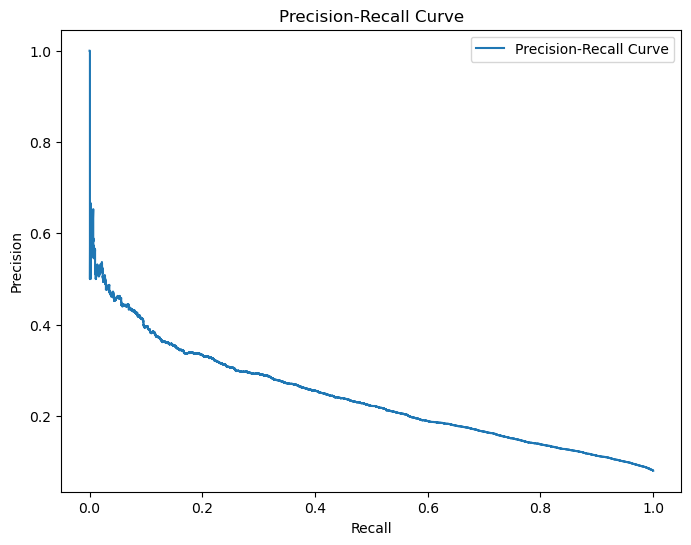

In [30]:
def plot_precision_recall_curve(model, X, y):
    y_probs = model.predict_proba(X)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y, y_probs)

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label='Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()
    
xgb_model = results['XGBoost']['model'].named_steps['model']
plot_precision_recall_curve(xgb_model, X_valid, y_valid)

In [40]:
def find_threshold_for_recall(model, X, y, target_recall):
    y_probs = model.predict_proba(X)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y, y_probs)

    # Find index where recall is closest to the target recall
    index = (np.abs(recall - target_recall)).argmin()

    # Corresponding threshold
    chosen_threshold = thresholds[index]

    return chosen_threshold

# Example: Choosing threshold for recall level of 0.8
target_recall = 0.5
chosen_threshold = find_threshold_for_recall(xgb_model, X_valid, y_valid, target_recall)
print(f"Chosen Threshold for Recall {target_recall}: {chosen_threshold}")


Chosen Threshold for Recall 0.5: 0.12945763766765594


In [45]:
def apply_threshold(model, X, threshold):
    y_probs = model.predict_proba(X)[:, 1]
    y_pred = (y_probs >= threshold).astype(int)
    return y_pred

# Example: Applying chosen threshold to make predictions
y_pred_thresholded = apply_threshold(xgb_model, X_valid, chosen_threshold)

In [ ]:
feature_importance_df = pd.DataFrame(list(results['XGBoost']['feature_importance'].items()), columns=['Feature', 'Importance'])
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
feature_importance_df

In [ ]:
results

In [14]:
results['DecisionTree']['model'].named_steps['model']

DecisionTreeClassifier(class_weight='balanced', max_depth=7,
                       min_samples_leaf=58, random_state=1)

In [15]:
print("Model ROC AUC Scores:")
for model_name, result in results.items():
    print(f"{model_name}: {result['best_score']:.3}")

Model ROC AUC Scores:
DecisionTree: 0.257
XGBoost: 0.0145
LGBM: 0.268
CatBoost: 0.268


As we can see, our models perfom very good at the provided task. **All presenting f1-score above 0.95** for the majority class. The best model was obtained with an XGBoost.

Although these are coefficients provided in a cross-validation setting, **due to our large amount of data, we will use a separate validation set to check the results**.

We will start by cleaning some of the variables on the memory, loading the validation dataset and applying the necessary pipelines.

Let's define variables for our best models and run the predictions

In [42]:
dt_model = results['DecisionTree']['model'].named_steps['model']
xgb_model = results['XGBoost']['model'].named_steps['model']
lgbm_model = results['LGBM']['model'].named_steps['model']
catb_model = results['CatBoost']['model'].named_steps['model']

y_dt = dt_model.predict(X_valid)
y_xgb = xgb_model.predict(X_valid)
y_lgbm = lgbm_model.predict(X_valid)
y_catb = catb_model.predict(X_valid)

# predict probabilities
probs_dt = dt_model.predict_proba(X_valid)[:, 1]
probs_xgb = xgb_model.predict_proba(X_valid)[:, 1]
probs_lgbm = lgbm_model.predict_proba(X_valid)[:, 1]
probs_catb = catb_model.predict_proba(X_valid)[:, 1]

Let's evaluate these models first based on their f1-score and recall and then jump to the confusion matrices.

In [43]:
models = {
    'DecisionTree': (y_dt, probs_dt),
    'XGBoost': (y_xgb, probs_xgb),
    'LGBM': (y_lgbm, probs_lgbm),
    'CatBoost': (y_catb, probs_catb),
}

for model_name, y_pred in models.items():
    f1 = f1_score(y_valid, y_pred[0])
    recall = recall_score(y_valid, y_pred[0])
    print(f"{model_name}")
    print(f"F1-Score: {f1:.3f} ; Recall: {recall:.3f}\n")

DecisionTree
F1-Score: 0.247 ; Recall: 0.668

XGBoost
F1-Score: 0.009 ; Recall: 0.004

LGBM
F1-Score: 0.266 ; Recall: 0.678

CatBoost
F1-Score: 0.266 ; Recall: 0.663



The F1-Scores are very similar as for the training dataset. Highlighting that our models are not overfitting and simply predicting well. The XGBoost is kept as the best model with 0.98 recall.

Let's see the results in a **confusion matrix**. The values exposed there are normalized and represent percentages in relation to true values.

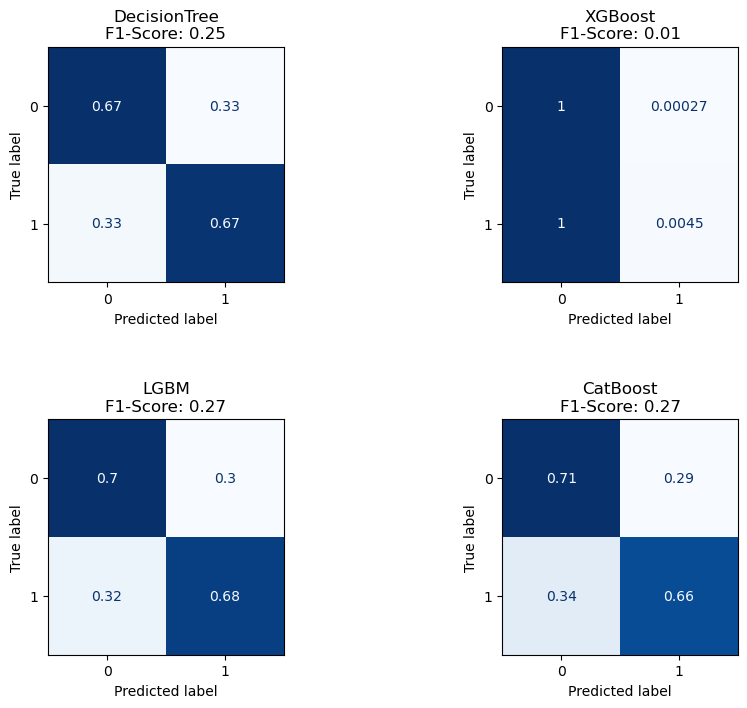

In [46]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

for model_name, y_pred, ax in zip(models.keys(), models.values(), axes.flatten()):
    cm_display = ConfusionMatrixDisplay.from_predictions(y_valid, y_pred[0], normalize='true',
                                                                  cmap='Blues', ax=ax, colorbar=False,)
                                                                  #display_labels=["Rejected", "Accepted"])
    f1 = f1_score(y_valid, y_pred[0])
    ax.set_title(f"{model_name}\nF1-Score: {f1:.2f}")

plt.tight_layout(pad=4)

These confusion matrices provided a good example of the importance of checking several metrics before choosing a model. As we can see, the XGBoost model does not perform so well for the minority class (84% correctly predicted as accepted).

All of the other models perform very well on both classes and solely based on that could be chosen as our model. The logistic regression performs slightly better at predicting clients who should have their loan accepted. Let's further evaluate before making a decision. 

Let's check the results in a **ROC_AUC Curve** to have another visual representation of the results.

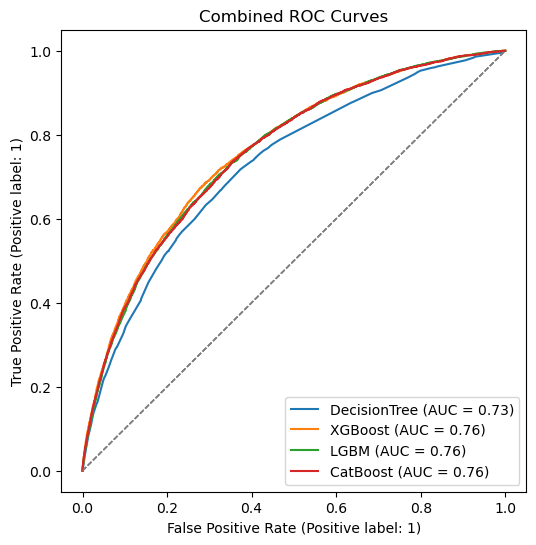

In [24]:
fig, ax = plt.subplots(figsize=(6, 6))
roc_displays = []

for model_name, y_pred in models.items():
    roc_display = RocCurveDisplay.from_predictions(y_valid, y_pred[1], name=model_name, ax=ax)
    roc_displays.append(roc_display)
    ax.plot([0, 1], [0, 1], color='grey', lw=1, linestyle='--')

ax.set_title("Combined ROC Curves");

This project highlighted that scoring a model for ROC AUC will not necessarily to optimize the area under the Precision-Recall curve (XGBoost example). And made me question if by choosing to score on f1 maybe I could have obtained more true positives for defaulters.

How to improve the model results:
- Invest time on the inexplored dataframes;
- Bring more aggregated features from the previous application/installments to the model;
- Compute interest rates;
- Create new aggregations for subsamples of the dataframes, i.e. NAME_PRODUCT_TYPE == "Approved"/"Cancelled", or CREDIT_ACTIVE == "bad debt"; 
- Try to impute values and check if there is increase in performance;

General improvements:
- To improve the workflow, some investiment can be done on the pipelines and creating mechanisms to integrate the data better;
- Correlations can be transformed into a function and put in EDA.py.